In [2]:
import numpy as np
import pystan
import matplotlib.pyplot as plt
import scipy.io

In [3]:
z = np.genfromtxt('z.txt', delimiter = ',')
B_zeta = scipy.io.loadmat('psivalues.mat')['psivalues']
tBB = B_zeta.T.dot(B_zeta)
n = B_zeta.shape[0]
p = B_zeta.shape[1]

In [4]:
X = B_zeta

In [5]:
hmc_code = '''
functions {
    vector S_xtheta(vector lambda, matrix X, int p, int n) {
        vector[n] s_is;
        for (N in 1:n) {
          s_is[N] = 1/sqrt(1 + sum((row(X, N).*square(to_row_vector(lambda))).*(row(X, N)))); 
        } 
        return(s_is);
    }
    }
data {
  int<lower=1> n; // Number of data
  int<lower=1> p; // Number of covariates
  matrix[n,p] X;  // n-by-p design matrix
  real y[n];      // n-dimensional response vector
}


parameters {
  vector[p] beta;
  vector<lower=0>[p] lambda;
  real<lower=0> tau;
}

transformed parameters {
  vector[n] theta ;
  vector[n] S ;
  vector[n] Var ;
  S = S_xtheta(lambda, X, p, n);
  theta = S .* (X * beta);
  Var = square(S);
}

model {
  tau ~ cauchy(0, 1);
  lambda ~ cauchy(0, tau);
  beta ~ normal(0, square(lambda)); 
  y ~ normal(theta, Var);
}'''

In [6]:
hmc_dat = {'n': n,
           'p': p,
           'X': X,
           'y': z}

In [7]:
sm = pystan.StanModel(model_code = hmc_code, verbose = True)
print('finished compiling')
print('start sampling')
fit = sm.sampling(data = hmc_dat,
                  iter = 500,
                  chains = 1, verbose = True)
print('finished sampling')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_678bd4eb54607bd2e668fb56be5d756d NOW.
INFO:pystan:OS: linux, Python: 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], Cython 0.29.21


Compiling /tmp/pystan_l_zmzxfk/stanfit4anon_model_678bd4eb54607bd2e668fb56be5d756d_4737211855232073887.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_l_zmzxfk/stanfit4anon_model_678bd4eb54607bd2e668fb56be5d756d_4737211855232073887.pyx
building 'stanfit4anon_model_678bd4eb54607bd2e668fb56be5d756d_4737211855232073887' extension
creating /tmp/pystan_l_zmzxfk/tmp
creating /tmp/pystan_l_zmzxfk/tmp/pystan_l_zmzxfk
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_l_zmzxfk -I/home/hofmancl/.local/lib/python3.8/site-packages/pystan -I/home/hofmancl/.local/lib/python3.8/site-packages/pystan/stan/src -I/home/hofmancl/.local/lib/python3.8/site-packages/pystan/stan/lib/stan_math -I/home/hofman

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


finished sampling


In [ ]:
pystan.check_hmc_diagnostics(fit)

In [10]:
samples = fit.extract(permuted=True)

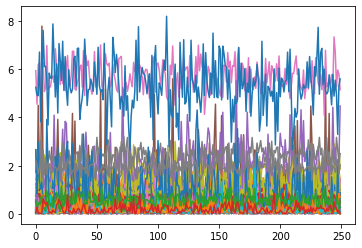

In [12]:
plt.plot(samples['lambda'])

In [62]:
beta = np.mean(samples['beta'], axis = 0)
beta_sd = np.std(samples['beta'], axis = 0)
Lambda = np.mean(np.log(samples['lambda']**2), axis = 0)
Lambda_sd = np.std(np.log(samples['lambda']**2), axis = 0)
tau = np.mean(np.log(samples['tau']), axis = 0)
tau_sd = np.std(np.log(samples['tau']), axis = 0)

In [ ]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('3000_samples_filtered.p', 'wb') as fp:
    pickle.dump(samples, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
la = fit.extract(permuted=True) 
a = fit.extract(permuted=False)

In [ ]:
fit.plot()

In [57]:
mu_va = np.load('../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts_boston.npy')
B_ts = np.load('../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts_boston.npy')
d_ts = np.load('../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts_boston.npy')

In [60]:
mu_va_m = np.mean(mu_va[2600:,:,:], axis = 0)
B_ts_m = np.mean(B_ts[2600:,:,:], axis = 0)
d_ts_m = np.mean(d_ts[2600:,:,:], axis = 0)

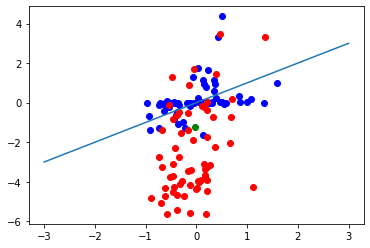

In [63]:
plt.scatter(mu_va_m[0:64], beta, color = 'b')
plt.scatter(mu_va_m[64:128], Lambda, color = 'r')
plt.scatter(mu_va_m[128], tau, color = 'g')
ident = [-3,3]
plt.plot(ident, ident)

In [61]:
var_va = np.sqrt(np.diag(B_ts_m.dot(B_ts_m.T) + np.diag(d_ts_m**2)))

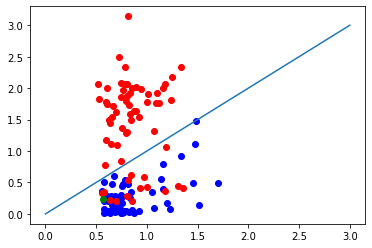

In [64]:
plt.scatter(var_va[0:64], beta_sd, color = 'b')
plt.scatter(var_va[64:128], Lambda_sd, color = 'r')
plt.scatter(var_va[128], tau_sd, color = 'g')
ident = [0,3]
plt.plot(ident, ident)